In [2]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Final Custom CNN with Accuracy Improvements and Grad-CAM
This notebook includes:
- Your original custom CNN (preserved structure)
- Accuracy improvements (BatchNorm, Dropout, Augmentation)
- Training with 20 Epochs and Early Stopping
- Grad-CAM Visualization
- Accuracy, Precision, Recall, F1, Confusion Matrix, ROC Curve


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import time
import seaborn as sns
import cv2
import torch.nn.functional as F


In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [6]:
# ✅ Accuracy improvement: Data Augmentation added here
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

data_path = "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Cervical Cancer"

full_dataset = datasets.ImageFolder(root=data_path, transform=transform)
class_names = full_dataset.classes

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [7]:
# ✅ DATASET SPLITTING (TRAIN / VALIDATION / TEST)
from torch.utils.data import random_split, DataLoader

# Assuming full_dataset is already defined
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# ✅ Print dataset sizes
print(f"Total dataset size: {len(full_dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Total dataset size: 25000
Training set size: 17500
Validation set size: 3750
Test set size: 3750


In [8]:
# ✅ Custom CNN with BatchNorm and Dropout added for accuracy
class CustomCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = CustomCNN(num_classes=len(class_names)).to(device)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
from copy import deepcopy

num_epochs = 20  # ✅ Increased to 20

best_loss = np.inf
patience_counter = 0

train_losses, val_losses = [], []

best_model_wts = deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # ✅ Now this is at the correct indentation level:
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}", flush=True)



Epoch 1/20 | Train Loss: 3.1914 | Val Loss: 0.4997
Epoch 2/20 | Train Loss: 0.6583 | Val Loss: 0.4749
Epoch 3/20 | Train Loss: 0.6025 | Val Loss: 0.4789
Epoch 4/20 | Train Loss: 0.5755 | Val Loss: 0.4376
Epoch 5/20 | Train Loss: 0.5588 | Val Loss: 0.4615
Epoch 6/20 | Train Loss: 0.5543 | Val Loss: 0.3760
Epoch 7/20 | Train Loss: 0.5462 | Val Loss: 0.6290
Epoch 8/20 | Train Loss: 0.4959 | Val Loss: 0.5440
Epoch 9/20 | Train Loss: 0.4731 | Val Loss: 0.3831
Epoch 10/20 | Train Loss: 0.4524 | Val Loss: 0.9624
Epoch 11/20 | Train Loss: 0.4359 | Val Loss: 1.1124
Epoch 12/20 | Train Loss: 0.4274 | Val Loss: 0.2591
Epoch 13/20 | Train Loss: 0.3992 | Val Loss: 0.7203
Epoch 14/20 | Train Loss: 0.3882 | Val Loss: 0.2868
Epoch 15/20 | Train Loss: 0.3592 | Val Loss: 0.2641
Epoch 16/20 | Train Loss: 0.3263 | Val Loss: 0.2492
Epoch 17/20 | Train Loss: 0.3251 | Val Loss: 0.2715
Epoch 18/20 | Train Loss: 0.3398 | Val Loss: 0.2586
Epoch 19/20 | Train Loss: 0.3008 | Val Loss: 0.2760
Epoch 20/20 | Train L

              precision    recall  f1-score   support

  cervix_dyk       0.99      0.94      0.97       767
  cervix_koc       0.92      0.88      0.90       755
  cervix_mep       0.90      0.97      0.93       771
  cervix_pab       0.99      1.00      1.00       717
  cervix_sfi       0.95      0.97      0.96       740

    accuracy                           0.95      3750
   macro avg       0.95      0.95      0.95      3750
weighted avg       0.95      0.95      0.95      3750



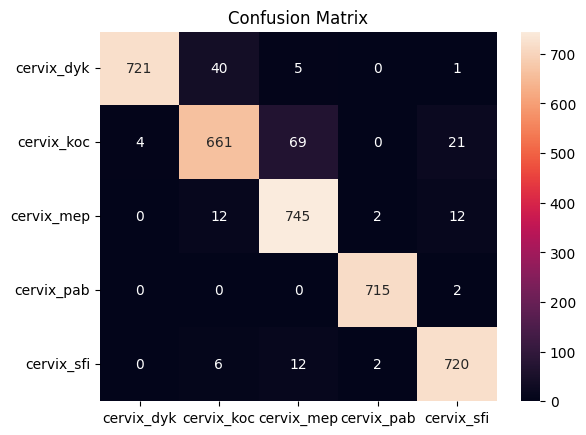

In [13]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=class_names))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


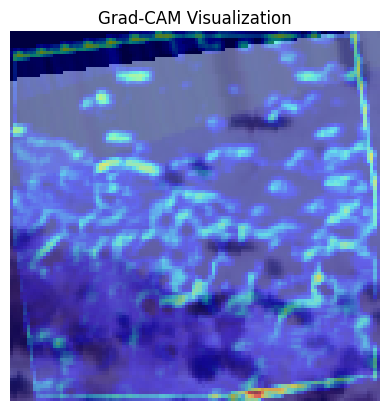

In [14]:
# ✅ Grad-CAM Section
from torchvision.models import resnet18
from torch.autograd import Function

# Pick last conv layer name from model
target_layer = model.conv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        input_tensor = input_tensor.to(device)

        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output)

        self.model.zero_grad()
        class_score = output[:, class_idx]
        class_score.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.detach()

        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu(), 0)
        heatmap /= torch.max(heatmap)
        return heatmap.numpy()

# Test Grad-CAM on a batch
dataiter = iter(val_loader)
images, labels = next(dataiter)
img = images[0].unsqueeze(0)

gradcam = GradCAM(model, target_layer)
heatmap = gradcam.generate(img)

# Plot Grad-CAM
img_np = img.squeeze().permute(1, 2, 0).cpu().numpy()
plt.imshow(img_np)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Visualization")
plt.axis('off')
plt.show()


# Timing: Training & Testing


In [23]:

# ==== Timing (Training & Testing) ====
# Safe-by-default: this will NOT retrain. Set `RETRAIN_WITH_TIMING=True` to retrain with timing.
import time

RETRAIN_WITH_TIMING = True# change to True if you want to retrain to measure training time

def train_with_timing(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    train_losses_timed, val_losses_timed = [], []
    epoch_times = []
    overall_start = time.time()
    for epoch in range(num_epochs):
        ep_start = time.time()
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        avg_train_loss = running_loss / len(train_loader.dataset)
        train_losses_timed.append(avg_train_loss)

        # ----- validation -----
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses_timed.append(avg_val_loss)

        ep_time = time.time() - ep_start
        epoch_times.append(ep_time)
        print(f"Epoch {epoch+1}/{num_epochs} - train_loss={avg_train_loss:.4f} val_loss={avg_val_loss:.4f} epoch_time={ep_time:.2f}s")

    total_train_time = time.time() - overall_start
    per_sample_time = total_train_time / (len(train_loader.dataset) * num_epochs)
    return {
        "train_losses": train_losses_timed,
        "val_losses": val_losses_timed,
        "epoch_times": epoch_times,
        "total_train_time_sec": total_train_time,
        "avg_time_per_sample_sec": per_sample_time
    }

TRAIN_TIMING = None
if RETRAIN_WITH_TIMING:
    # Uses already-defined: model, train_loader, val_loader, criterion, optimizer, num_epochs, device
    # (This will reinitialize optimizer state; if you want to start fresh, reinit the model before calling)
    TRAIN_TIMING = train_with_timing(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    print("\n[Training Timing]")
    print(f"Total training time: {TRAIN_TIMING['total_train_time_sec']:.2f} sec")
    print(f"Average time per sample per epoch: {TRAIN_TIMING['avg_time_per_sample_sec']:.6f} sec")
else:
    print("Skipping retraining. Set RETRAIN_WITH_TIMING=True to measure training time.")
    
# ----- Test (inference) timing -----
model.eval()
test_start = time.time()
total_test_images = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        _ = model(images)
        total_test_images += images.size(0)
test_total_time = time.time() - test_start
test_time_per_image = test_total_time / max(1, total_test_images)
print("\n[Test Timing]")
print(f"Total test (inference) time: {test_total_time:.2f} sec for {total_test_images} images")
print(f"Average inference time per image: {test_time_per_image:.6f} sec")



Epoch 1/20 - train_loss=0.2831 val_loss=0.1735 epoch_time=170.99s
Epoch 2/20 - train_loss=0.2902 val_loss=0.2109 epoch_time=155.05s
Epoch 3/20 - train_loss=0.2720 val_loss=0.1621 epoch_time=156.42s
Epoch 4/20 - train_loss=0.2785 val_loss=1.1229 epoch_time=153.75s
Epoch 5/20 - train_loss=0.2498 val_loss=0.1731 epoch_time=155.09s
Epoch 6/20 - train_loss=0.2643 val_loss=0.1440 epoch_time=157.83s
Epoch 7/20 - train_loss=0.2426 val_loss=0.2035 epoch_time=160.23s
Epoch 8/20 - train_loss=0.2557 val_loss=18.3943 epoch_time=158.37s
Epoch 9/20 - train_loss=0.2614 val_loss=0.1418 epoch_time=156.00s
Epoch 10/20 - train_loss=0.2300 val_loss=0.2285 epoch_time=155.35s
Epoch 11/20 - train_loss=0.2391 val_loss=0.1606 epoch_time=155.99s
Epoch 12/20 - train_loss=0.2369 val_loss=0.1525 epoch_time=156.09s
Epoch 13/20 - train_loss=0.2233 val_loss=0.1967 epoch_time=157.06s
Epoch 14/20 - train_loss=0.2094 val_loss=0.1429 epoch_time=202.79s
Epoch 15/20 - train_loss=0.2191 val_loss=0.1147 epoch_time=172.42s
Epo

# Dataset Insights & Examples


[Dataset Summary]
Total images: 25000 (train=17500, val=3750, test=3750)
Input image shape: (C=3, H=224, W=224)  => features=150528
Number of classes: 5
Classes: ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']


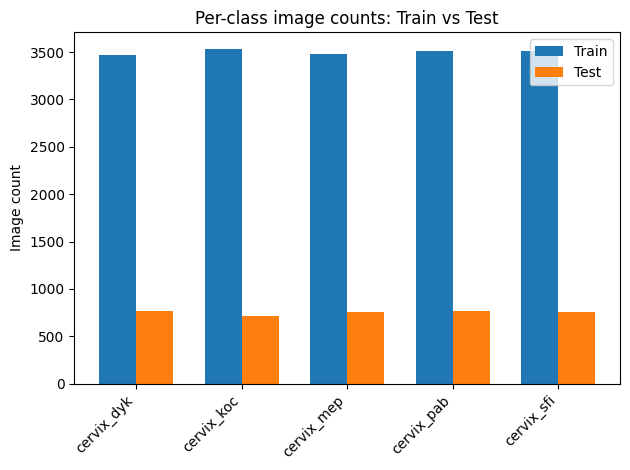

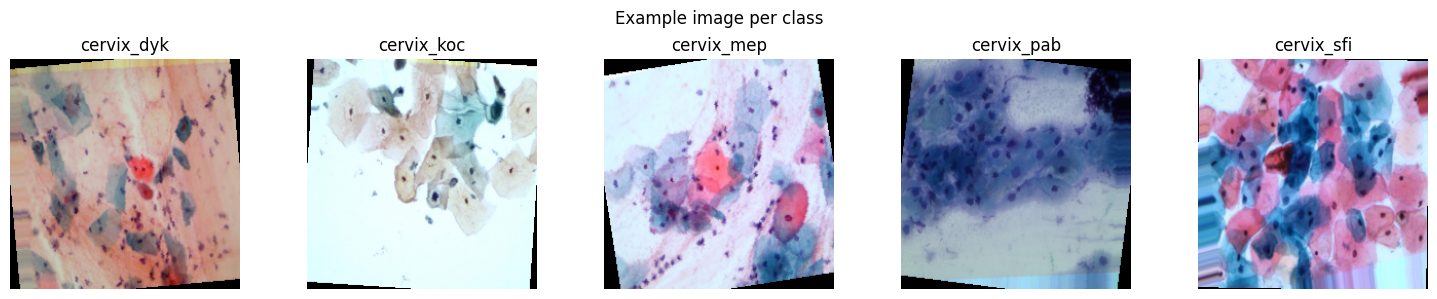

In [24]:

# ==== Dataset Details, Class Distribution, and Example Images ====
import numpy as np
import matplotlib.pyplot as plt

# Sizes
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
total_size = train_size + val_size + test_size

# Input feature shape (channels, height, width) from one batch
batch_images, batch_labels = next(iter(train_loader))
C, H, W = batch_images.shape[1:]
num_features = C * H * W

print("[Dataset Summary]")
print(f"Total images: {total_size} (train={train_size}, val={val_size}, test={test_size})")
print(f"Input image shape: (C={C}, H={H}, W={W})  => features={num_features}")
print(f"Number of classes: {len(class_names)}")
print("Classes:", class_names)

# Per-class counts by iterating loaders (robust to random_split)
def count_per_class(data_loader, num_classes):
    counts = np.zeros(num_classes, dtype=int)
    for images, labels in data_loader:
        labels_np = labels.numpy() if hasattr(labels, "numpy") else labels.cpu().numpy()
        for lbl in labels_np:
            counts[int(lbl)] += 1
    return counts

train_counts = count_per_class(train_loader, len(class_names))
test_counts = count_per_class(test_loader, len(class_names))

# Bar charts (train and test)
plt.figure()
x = np.arange(len(class_names))
width = 0.35
plt.bar(x - width/2, train_counts, width, label="Train")
plt.bar(x + width/2, test_counts, width, label="Test")
plt.xticks(x, class_names, rotation=45, ha="right")
plt.ylabel("Image count")
plt.title("Per-class image counts: Train vs Test")
plt.legend()
plt.tight_layout()
plt.show()

# Example image per class (from train set, fallback to test set if absent)
examples = {}
# Collect from train first
for images, labels in train_loader:
    for img, lbl in zip(images, labels):
        lbl = int(lbl.item())
        if lbl not in examples:
            examples[lbl] = img.detach().cpu()
        if len(examples) == len(class_names):
            break
    if len(examples) == len(class_names):
        break

# Fallback to test set if any class missing
if len(examples) < len(class_names):
    for images, labels in test_loader:
        for img, lbl in zip(images, labels):
            lbl = int(lbl.item())
            if lbl not in examples:
                examples[lbl] = img.detach().cpu()
            if len(examples) == len(class_names):
                break
        if len(examples) == len(class_names):
            break

# Plot example images in a grid
cols = min(5, len(class_names))
rows = int(np.ceil(len(class_names) / cols))
plt.figure(figsize=(cols*3, rows*3))
for idx, cls_idx in enumerate(sorted(examples.keys())):
    plt.subplot(rows, cols, idx+1)
    img = examples[cls_idx]
    # Convert CHW -> HWC safely
    if img.ndim == 3:
        img_np = img.permute(1,2,0).numpy()
        img_np = np.clip(img_np, 0, 1)  # assume normalized to [0,1]
    else:
        img_np = img.numpy()
    plt.imshow(img_np.squeeze())
    plt.title(f"{class_names[cls_idx]}")
    plt.axis("off")
plt.suptitle("Example image per class", y=0.98)
plt.tight_layout()
plt.show()


# Learning Curves & Accuracies


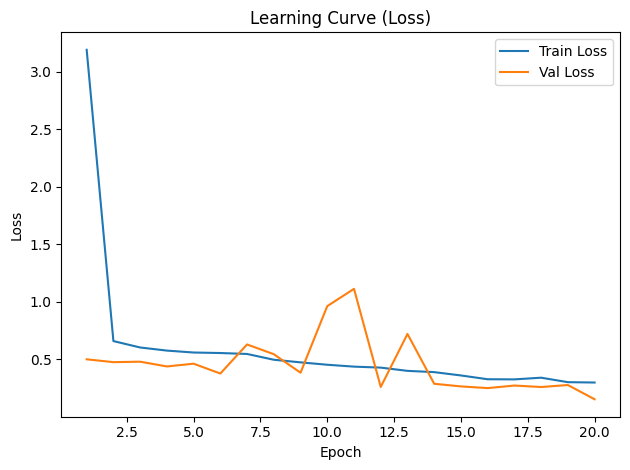

Train accuracy: 96.12%
Val accuracy:   95.28%
Test accuracy:  96.00%


In [25]:

# ==== Learning Curves (Loss) & Accuracy Snapshot ====
import matplotlib.pyplot as plt
import numpy as np

# Learning curves from existing lists if present; else fallback to timing run
tl = globals().get("train_losses", None)
vl = globals().get("val_losses", None)

if tl is None or vl is None:
    # Try from timing helper if retrained
    if isinstance(globals().get("TRAIN_TIMING"), dict):
        tl = TRAIN_TIMING.get("train_losses")
        vl = TRAIN_TIMING.get("val_losses")

if tl is not None and vl is not None:
    epochs_range = range(1, len(tl)+1)
    plt.figure()
    plt.plot(epochs_range, tl, label="Train Loss")
    plt.plot(epochs_range, vl, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Learning Curve (Loss)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Learning-curve arrays (train_losses/val_losses) not found. If you want this plot, ensure you keep track of losses during training or enable RETRAIN_WITH_TIMING.")
    
# Snapshot accuracies (post hoc) on train/val/test
def compute_accuracy(data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / max(1, total)

train_acc = compute_accuracy(train_loader)
val_acc = compute_accuracy(val_loader)
test_acc = compute_accuracy(test_loader)
print(f"Train accuracy: {train_acc*100:.2f}%")
print(f"Val accuracy:   {val_acc*100:.2f}%")
print(f"Test accuracy:  {test_acc*100:.2f}%")


# ROC & AUC


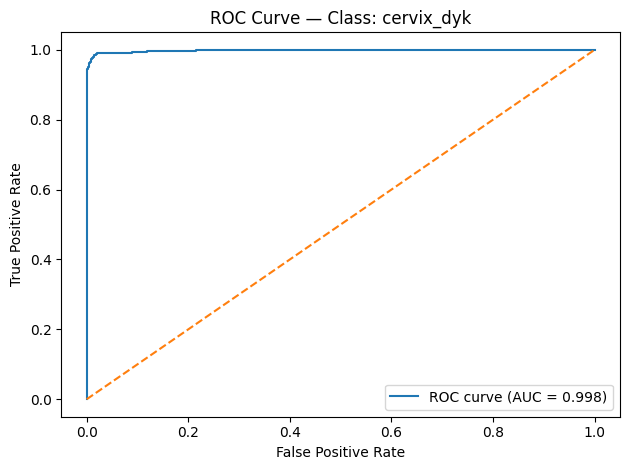

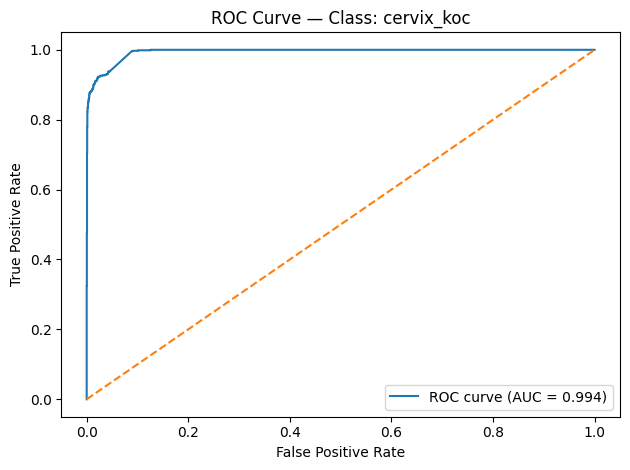

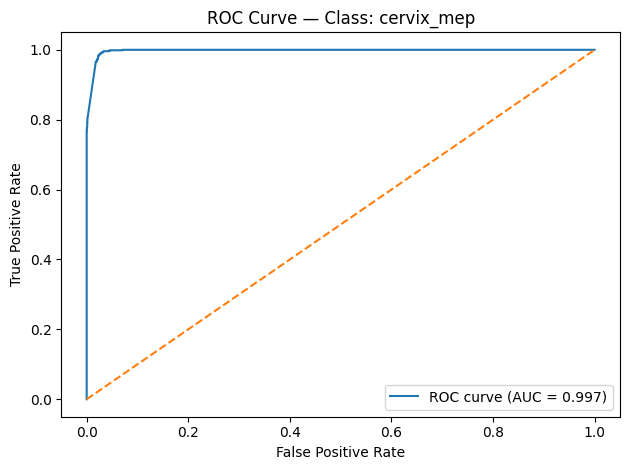

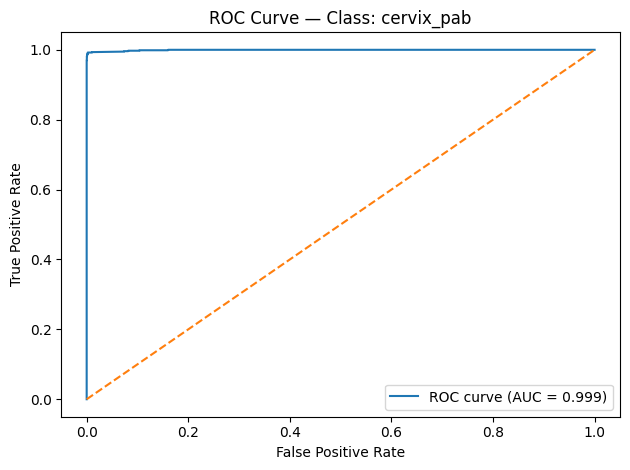

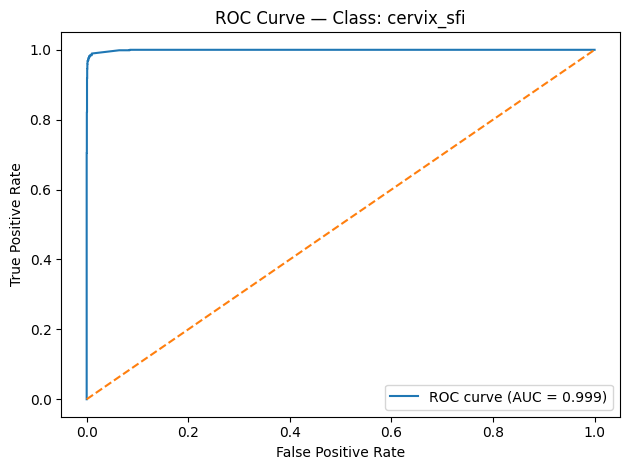

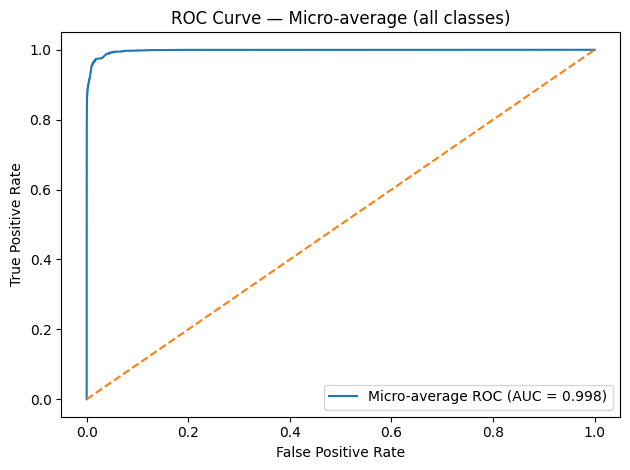

[AUC scores]
Class 'cervix_dyk': AUC = 0.9983
Class 'cervix_koc': AUC = 0.9939
Class 'cervix_mep': AUC = 0.9974
Class 'cervix_pab': AUC = 0.9994
Class 'cervix_sfi': AUC = 0.9993
Micro-average AUC: 0.9979
Macro-average AUC: 0.9977


In [26]:

# ==== ROC & AUC (One-vs-Rest for Multi-class) ====
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

model.eval()
y_true = []
y_scores = []  # softmax probabilities

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        y_scores.append(probs.cpu().numpy())
        y_true.append(labels.numpy())

import numpy as np
y_scores = np.vstack(y_scores)  # shape [N, C]
y_true = np.concatenate(y_true) # shape [N]

# Binarize labels for OvR ROC
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))  # shape [N, C]

# Compute per-class ROC and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
# Average the AUCs
roc_auc["macro"] = np.mean([roc_auc[i] for i in range(n_classes)])

# Plot per-class ROC
import matplotlib.pyplot as plt

for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label=f"ROC curve (AUC = {roc_auc[i]:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — Class: {class_names[i]}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# Plot micro-average ROC
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average ROC (AUC = {roc_auc['micro']:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Micro-average (all classes)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print("[AUC scores]")
for i in range(n_classes):
    print(f"Class '{class_names[i]}': AUC = {roc_auc[i]:.4f}")
print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
print(f"Macro-average AUC: {roc_auc['macro']:.4f}")
